In [1]:
import pandas as pd
from graph_tool.all import *
import numpy as np
from collections import defaultdict
import heapq

In [2]:
games       = pd.read_csv('nfl-big-data-bowl-2025/games.csv')
plays       = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
players     = pd.read_csv('nfl-big-data-bowl-2025/players.csv')
player_play = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')

In [3]:
plays_subset = plays[[
    'gameId','playId','possessionTeam',
    'expectedPoints','expectedPointsAdded','yardsGained'
]]
player_play = player_play.merge(
    plays_subset, on=['gameId','playId'], how='left'
).merge(
    games[['gameId','week']], on='gameId', how='left'
)

print(player_play.head())

       gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0  2022090800      56  35472      BUF               0             0   
1  2022090800      56  42392      BUF               0             0   
2  2022090800      56  42489      BUF               0             0   
3  2022090800      56  44875      BUF               0             0   
4  2022090800      56  44985      BUF               0             0   

   hadDropback  passingYards  sackYardsAsOffense  hadPassReception  ...  \
0            0             0                   0                 0  ...   
1            0             0                   0                 0  ...   
2            0             0                   0                 1  ...   
3            0             0                   0                 0  ...   
4            0             0                   0                 0  ...   

   pressureAllowedAsBlocker  timeToPressureAllowedAsBlocker  \
0                       0.0                             NaN

In [5]:
team = 'CAR'  # e.g. Carolina Panthers

def_plays = player_play[player_play['possessionTeam'] != team]
team_player_pp = player_play[player_play['teamAbbr'] == team]


In [6]:
pos_map = {
  'CB':'DB','S':'DB','FS':'DB','SS':'DB','DB':'DB',
  'LB':'LB','ILB':'LB','OLB':'LB','MLB':'LB',
  'DE':'DL','DT':'DL','DL':'DL'
}
players['positionGroup'] = players['position'].map(pos_map).fillna('Other')
def_play_ids = set(team_player_pp['nflId'].dropna())

In [ ]:
player_stats   = defaultdict(lambda: [0.0, 0])
co_occurrence  = defaultdict(lambda: defaultdict(lambda: [0.0, 0]))
game_ids       = def_plays['gameId'].unique()

for gid in game_ids:
    sub = def_plays[def_plays['gameId'] == gid]
    for _, row in sub.iterrows():
        pid     = row['playId']
        def_epa = -row['expectedPointsAdded']  # invert EPA
        
        on_field = team_player_pp[
            (team_player_pp['gameId']==gid) &
            (team_player_pp['playId']==pid)
        ]
        defender_ids = on_field['nflId'].dropna().unique()
        
        for p in defender_ids:
            player_stats[p][0] += def_epa
            player_stats[p][1] += 1
        
        for i, p1 in enumerate(defender_ids):
            for p2 in defender_ids[i+1:]:
                co_occurrence[p1][p2][0] += def_epa
                co_occurrence[p1][p2][1] += 1
                co_occurrence[p2][p1][0] += def_epa
                co_occurrence[p2][p1][1] += 1

In [ ]:
gx = Graph(directed=False)

vp_id        = gx.new_vertex_property("int")
vp_name      = gx.new_vertex_property("string")
vp_position  = gx.new_vertex_property("string")
vp_group     = gx.new_vertex_property("string")
vp_epa       = gx.new_vertex_property("double")
vp_plays     = gx.new_vertex_property("int")


ep_plays     = gx.new_edge_property("int")
ep_epa       = gx.new_edge_property("double")


vertex_map = {}


for nflId, stats in player_stats.items():
    if nflId not in vertex_map:
        v = gx.add_vertex()
        vertex_map[nflId] = v

        # fill in props
        info = players[players['nflId'] == nflId]
        vp_id[v]       = int(nflId)
        vp_name[v]     = info.iloc[0]['displayName'] if not info.empty else f"Player {nflId}"
        pos            = info.iloc[0]['position']    if not info.empty else 'NaN'
        grp            = pos_map.get(pos, 'Other')
        vp_position[v] = pos
        vp_group[v]    = grp

        played = stats[1]
        vp_plays[v]    = played
        vp_epa[v]      = (stats[0]/played) if played>0 else 0.0


for p1, targets in co_occurrence.items():
    for p2, (tot_epa, count) in targets.items():
        if count>0 and p1 in vertex_map and p2 in vertex_map:
            v1 = vertex_map[p1]
            v2 = vertex_map[p2]
            e  = gx.add_edge(v1, v2)
            ep_plays[e] = count
            ep_epa[e]   = tot_epa/count


gx.vertex_properties["nflId"]       = vp_id
gx.vertex_properties["name"]        = vp_name
gx.vertex_properties["position"]    = vp_position
gx.vertex_properties["positionGroup"]= vp_group
gx.vertex_properties["epa_per_play"]= vp_epa
gx.vertex_properties["plays"]       = vp_plays

gx.edge_properties["coPlays"]       = ep_plays
gx.edge_properties["epa_per_pair"]  = ep_epa

In [9]:
e = eigenvector(gx)
eig = e[1] if isinstance(e, tuple) else e
gx.vertex_properties["eigenvector"] = eig

# find top 5 defenders by network centrality
pq = []
for v in gx.vertices():
    heapq.heappush(pq, (eig[v], v))
    if len(pq)>5:
        heapq.heappop(pq)
top5 = sorted(pq, reverse=True)
print("Top 5 defenders by eigenvector centrality:")
for score, v in top5:
    print(f"{vp_name[v]} ({vp_group[v]}): centrality={score:.4f}, EPA/play={vp_epa[v]:.4f}")


Top 5 defenders by eigenvector centrality:
Myles Hartsfield (DB): centrality=0.2066, EPA/play=-0.0502
Marquan McCall (Other): centrality=0.2034, EPA/play=-0.1549
Damien Wilson (LB): centrality=0.2034, EPA/play=0.1177
Yetur Gross-Matos (LB): centrality=0.2034, EPA/play=0.0120
Xavier Woods (DB): centrality=0.2034, EPA/play=0.0261


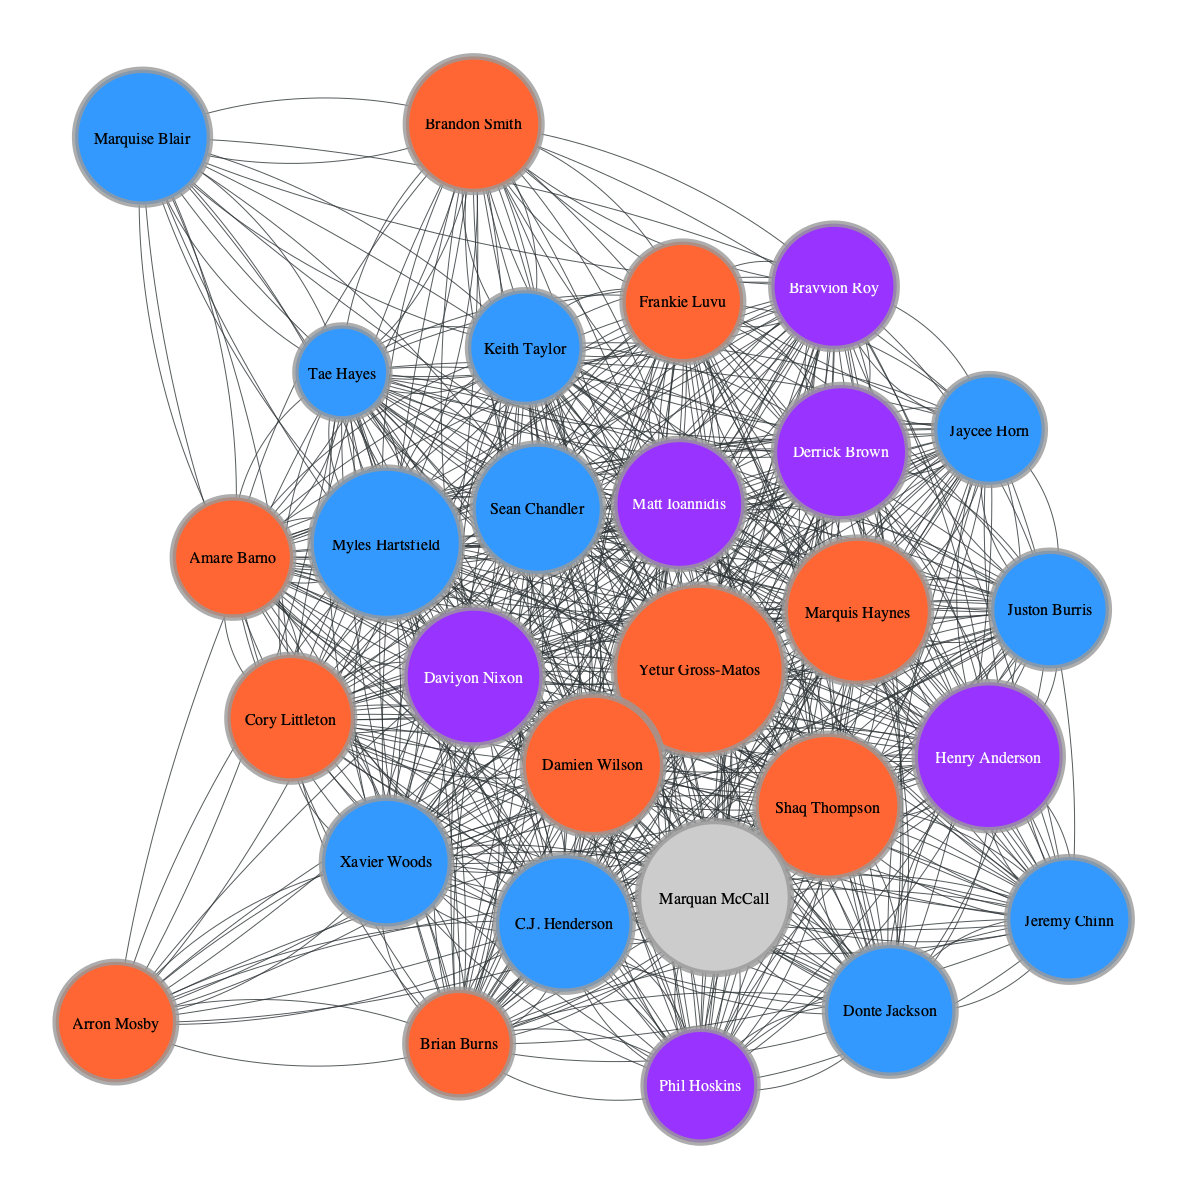

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1544b3230, at 0x16e352970>

In [10]:
pos = sfdp_layout(gx)
color_map = {
    'DB':[0.2,0.6,1.0,1.0],
    'LB':[1.0,0.4,0.2,1.0],
    'DL':[0.6,0.2,1.0,1.0],
    'Other':[0.8,0.8,0.8,1.0]
}
vp_color = gx.new_vertex_property("vector<double>")
for v in gx.vertices():
    grp = vp_group[v]
    vp_color[v] = color_map.get(grp, color_map['Other'])

graph_draw(
    gx, pos=pos, vertex_fill_color=vp_color,
    vertex_text=vp_name, vertex_font_size=8,
    edge_pen_width=0.5
)